Python 3.11.5

In [1]:
%pip install numpy -q
%pip install pandas -q
%pip install scikit-learn -q
%pip install torch -q
%pip install transformers -q
%pip install gensim -q
%pip install -U sentence-transformers -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import nltk

path_data = "Data/"

!bash downloads.bash $path_data

nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
The data were already unpacked


[nltk_data] Downloading package stopwords to /home/keddie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
import numpy as np
import pandas as pd
import os
import torch
from collections import defaultdict
import json
import pickle

print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.nn import CosineSimilarity

Cuda available: True


In [7]:
from data_processing import get_text_from_xml

directive_data = get_text_from_xml(path_data + "DIR_EN_32002L0044.xml")
provision_data = get_text_from_xml(path_data + "NIM_EN.xml")

labels = json.load(open("labels.json", "rb"))

In [4]:
cos = CosineSimilarity(dim = 0)

def euclidean_distance(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    auxiliary = torch.subtract(x, y)
    auxiliary = torch.pow(auxiliary, 2)
    auxiliary = torch.sum(auxiliary, dim = 0)
    auxiliary = torch.sqrt(auxiliary)

    return auxiliary

def jaccard_score(x: set, y: set) -> float:
    return len(x & y)/len(x | y)

## BoW one-hot encoding

In [12]:
from collections import defaultdict

def encode_sentence_bow(sentence: str, vocab: defaultdict|dict) -> np.ndarray:
     return np.asarray([int(vocab_token in sentence) for vocab_token in vocab.keys()])

def create_vocabulary(data: pd.Series) -> defaultdict:
     vocabulary = defaultdict(int)

     for sentence in data:
          for token in sentence:
               vocabulary[token] += 1

     vocabulary = dict(sorted(vocabulary.items())) # avoid situations such as [1 1 1 1 0 0 ...]

     return vocabulary

def encode_bow(x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
     vocab = create_vocabulary(x_data["Text"])
     x_data["Encoded_Text"] = x_data["Text"].apply(func = encode_sentence_bow, args = (vocab,))
     y_data["Encoded_Text"] = y_data["Text"].apply(func = encode_sentence_bow, args = (vocab,))

     return x_data, y_data

## TFIDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(stop_words = None, lowercase = False, binary = True) # base bare bones tfidf no stop words

In [14]:
def encode_tfidf(x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    x_aux = [" ".join(text[:]) for text in x_data["Text"]]
    y_aux = [" ".join(text[:]) for text in y_data["Text"]]

    x_encoded = tfidf_model.fit_transform(x_aux)
    y_encoded = tfidf_model.transform(y_aux)

    x_data["Encoded_Text"] = list(x_encoded.toarray())
    y_data["Encoded_Text"] = list(y_encoded.toarray())

    return x_data, y_data

## Lexical similarity with Jaccard scoring
$J(D_1, D_2)=\frac{|D_1 \cap D_2|}{|D_1 \cup D_2|}$

In [10]:
# def jaccard_scoring(directive_data: pd.DataFrame, provision_data: pd.DataFrame, threshold: int = 0.35, top_n: int = 3) -> defaultdict:
#     predicted_labels = defaultdict()

#     avg_s = []
#     for id, directive in zip(directive_data["ID"], directive_data["Text"]):
#         directive = set(directive)
#         scores = []
#         for provision in provision_data["Text"]:
#             provision = set(provision)
#             scores.append(jaccard_score(directive, provision))

#         scores = np.asarray(scores)
#         avg_s.append(scores)

#         best_idx = np.argsort(scores)[::-1][:top_n]

#         idx = 0
#         aux = []
#         while idx < len(best_idx):
#             if scores[best_idx[idx]] < threshold:
#                 break
#             aux.append(best_idx[idx])
#             idx += 1

#         best_idx = aux
#         label = provision_data.iloc[best_idx]["ID"].to_list() if len(best_idx) > 0 else ["Null"]
#         predicted_labels[id] = label

#     pickle.dump(np.mean(avg_s, 1), open("Auxiliary_Items/sim/sim_score_Jaccard.npy", "wb"))
#     return predicted_labels

## Transformer embeddings - BERT (English, base, uncased) \
use preprocessed text not original even though context matters bcs. there are MANY unique sub-words (e.g. 89/391/EEC)

In [11]:
from transformers import BertTokenizer, BertModel

model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model_transformer = BertModel.from_pretrained(model_name).to(device)

In [15]:
from transformers import BatchEncoding

def encode_sentence_transformer(sentences: pd.Series) -> torch.Tensor:

    encoded = []
    for idx in range(len(sentences)):
        sentence = " ".join(sentences[idx])
        tokenized_sentence = tokenizer(sentence, max_length = 512, padding = "max_length", truncation = True, return_tensors = "pt", return_attention_mask = True)
        aux = {}
        for key, value in tokenized_sentence.items():
            aux[key] = value.to(device)
        tokenized_sentence = BatchEncoding(aux)
        model_output = model_transformer(**tokenized_sentence)

        last_hidden_state = model_output.last_hidden_state[0]

        attention_mask = tokenized_sentence.attention_mask[0]
        attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        data_attention = last_hidden_state * attention_mask
        sentence_vector = torch.sum(data_attention, 0)/torch.clamp(attention_mask.sum(0), min = 1e-9)

        encoded.append(np.array(sentence_vector.cpu().detach().numpy()))

    return encoded

def encode_transformer(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    data["Encoded_Text"] = encode_sentence_transformer(data["Text"].to_numpy())

    return data


## Sentence Transformer

In [2]:
from sentence_transformers import SentenceTransformer

model_sentence = SentenceTransformer("all-distilroberta-v1").to(device)

In [16]:
def encode_sentence_stransformer(text: list) -> torch.Tensor:
    return model_sentence.encode(" ".join(text))

def encode_stransformer(data: pd.DataFrame) -> pd.DataFrame:
    data["Encoded_Text"] = data["Text"].apply(encode_sentence_stransformer)

    return data

## Evaluation metrics

$Acc = \frac{TP+TN}{TP+TN+FP+FN}$\
$P = \frac{TP}{TP+FP}$\
$R = \frac{TP}{TP+FN}$\
$F1 = \frac{2\cdot P\cdot R}{P+R}$

In [31]:
current_encoding = ""
def compute_similarity(directive_data: pd.DataFrame, provision_data: pd.DataFrame, similarity_function: callable = cos, threshold: float|int = 1, top_n: int = 3) -> list:
    if similarity_function == jaccard_score:
        dir_matrix = directive_data.copy()["Text"].apply(lambda x: set(x))
        pro_matrix = provision_data.copy()["Text"].apply(lambda x: set(x))
    else:
        dir_matrix = torch.from_numpy(np.asarray(directive_data["Encoded_Text"].tolist(), dtype=float))
        pro_matrix = torch.from_numpy(np.asarray(provision_data["Encoded_Text"].tolist(), dtype=float))

    avg_s = []
    labels_pred = defaultdict()
    for id, d1 in zip(directive_data["ID"], dir_matrix):
        scores = []
        for d2 in pro_matrix:
            score = similarity_function(d1, d2)
            scores.append(score.item() if torch.is_tensor(score) else score)

        scores = np.asarray(scores)
        avg_s.append(scores)

        if similarity_function != cos:
            name_similarity = "euclidean"
            threshold_check = lambda x: x >= threshold
            best_idx = np.argsort(scores)[::][:top_n]
        else:
            name_similarity = "cos" if similarity_function != jaccard_score else "jaccard"
            threshold_check = lambda x: x < threshold
            best_idx = np.argsort(scores)[::-1][:top_n]

        idx = 0
        aux = []
        while idx < len(best_idx):
            if threshold_check(scores[best_idx[idx]]):
                break
            aux.append(best_idx[idx])
            idx += 1

        best_idx = aux
        label = provision_data.iloc[best_idx]["ID"].to_list() if len(best_idx) > 0 else ["Null"]
        labels_pred[id] = label

    pickle.dump(np.mean(avg_s, 1), open(f"Auxiliary_Items/sim/sim_score_{current_encoding}_{name_similarity}.npy", "wb"))
    return labels_pred

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

def binarize_labels(input_labels: list, all_labels: list) -> list:
    all_labels = [label for labels in all_labels for label in labels]
    all_labels.sort()
    all_labels = sorted(set(all_labels), key=all_labels.index)

    binary_labels = []
    for input_ids in input_labels:
        binary_ids = []
        for id in all_labels:
            binary_ids.append(int(id in input_ids))

        binary_labels.append(binary_ids)

    return np.asarray(binary_labels)

def evaluation(predicted_labels: defaultdict, true_labels: defaultdict) -> (dict, np.ndarray):
    true_binary = binarize_labels(list(true_labels.values()), list(true_labels.values()))
    predicted_binary = binarize_labels(list(predicted_labels.values()), list(true_labels.values()))

    results = classification_report(true_binary, predicted_binary, output_dict = True, zero_division = 0) # accuracy + precision + recall + f1 
    confusion_matrix = multilabel_confusion_matrix(true_binary, predicted_binary)

    return results, confusion_matrix

## Evaluation of models

In [22]:
# wrapper function
def encode(encoding_method: callable, x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    if encoding_method == encode_bow or encoding_method == encode_tfidf:
        x_data, y_data = encoding_method(x_data, y_data)
    else:
        x_data = encoding_method(x_data)
        y_data = encoding_method(y_data)

    return x_data, y_data

def predict(x_data: pd.DataFrame, y_data: pd.DataFrame, **kwargs) -> defaultdict:
    # print("Warning: Jaccard prediction does not use any other similarity functions") if predict_method == jaccard_scoring and "similarity_function" in kwargs.keys() else 1

    # if predict_method == jaccard_scoring:
    #     predicted_labels = jaccard_scoring(x_data, y_data, kwargs["threshold"], kwargs["top_n"])
    # else:
    predicted_labels = compute_similarity(x_data, y_data, kwargs["similarity_function"], kwargs["threshold"], kwargs["top_n"])

    return predicted_labels

In [48]:
evaluation_pairs = {
    "Jaccard Scoring": (None, [0.21]),
    "BoW": (encode_bow, [0.27, 3.5]),
    "tfidf": (encode_tfidf, [0.2, 1.1]),
    "Transformer": (encode_transformer, [0.89, 2.6]),
    "Sentence Transformer": (encode_stransformer, [0.7, 0.9])
}

similarity_functions = [cos, euclidean_distance, jaccard_score]
scores = defaultdict(dict)
for method, (encoding_method, thresholds) in evaluation_pairs.items():
    print(method)
    current_encoding = method
    if encoding_method != None:
        directive_data, provision_data = encode(encoding_method = encoding_method, x_data = directive_data, y_data = provision_data)

    for similarity, threshold in zip(similarity_functions, thresholds):
        if method != "Jaccard Scoring" and similarity == jaccard_score:
            continue
        predicted_labels = predict(directive_data, provision_data, similarity_function = similarity, threshold = threshold, top_n = 3)
        metrics = evaluation(predicted_labels, labels)
        if method == "Jaccard Scoring":
            similarity = "Jaccard"
            scores[method][similarity] = metrics
            break

        if similarity == euclidean_distance:
            similarity = "Euclidean"
        elif similarity == cos:
            similarity = "Cosine Similarity"

        scores[method][similarity] = metrics

# np.sum(scores["Transformer"]["Euclidean"][1], 0)/31


Jaccard Scoring
BoW
tfidf
Transformer
Sentence Transformer


In [323]:
predicted_labels

defaultdict(None,
            {'A1_1': ['P7', 'P6_1', 'P3'],
             'A1_2': ['P3', 'P6_1', 'P7'],
             'A1_3': ['Null'],
             'A2': ['P7', 'P2'],
             'A3_1': ['P4_1', 'P4_2', 'P5_4'],
             'A3_2': ['P4_2', 'P4_1', 'P5_4'],
             'A4_1': ['P5_2', 'P7', 'P5_1'],
             'A4_2': ['P5_4', 'P6_2', 'P5_2'],
             'A4_3': ['P5_2', 'P6_2', 'P5_5'],
             'A4_4': ['P5_4', 'P6_2', 'P7'],
             'A4_5': ['P7', 'P6_2', 'P8_1'],
             'A5_1': ['P6_1', 'P5_4', 'P6_2'],
             'A5_2': ['P6_2', 'P5_4', 'P5_2'],
             'A5_3': ['Null'],
             'A5_4': ['P10_3', 'P8_1', 'P3'],
             'A6': ['P7', 'P8_1', 'P5_4'],
             'A7': ['Null'],
             'A8_1': ['P8_1', 'P8_8', 'P8_6'],
             'A8_2': ['P8_5', 'P8_3', 'P8_4'],
             'A8_3': ['P8_8', 'P8_6', 'P8_2'],
             'A9': ['P9_2'],
             'A10_1': ['P8_1', 'P10_1', 'P6_1'],
             'A10_2': ['P10_2', 'P5_4', 'P3'],


In [49]:
scores

defaultdict(dict,
            {'Jaccard Scoring': {'Jaccard': ({'0': {'precision': 0.0,
                 'recall': 0.0,
                 'f1-score': 0.0,
                 'support': 9.0},
                '1': {'precision': 0.16666666666666666,
                 'recall': 1.0,
                 'f1-score': 0.2857142857142857,
                 'support': 1.0},
                '2': {'precision': 1.0,
                 'recall': 1.0,
                 'f1-score': 1.0,
                 'support': 1.0},
                '3': {'precision': 0.25,
                 'recall': 1.0,
                 'f1-score': 0.4,
                 'support': 1.0},
                '4': {'precision': 0.3333333333333333,
                 'recall': 1.0,
                 'f1-score': 0.5,
                 'support': 1.0},
                '5': {'precision': 0.3333333333333333,
                 'recall': 1.0,
                 'f1-score': 0.5,
                 'support': 1.0},
                '6': {'precision': 0.2,
          

In [50]:
avg_methods = ["micro avg", "macro avg", "samples avg", "weighted avg"]

all_scores = []
similarity_functions = ["Jaccard", "Cosine Similarity", "Euclidean"]

for encoding in evaluation_pairs.keys():
    if encoding == "Jaccard Scoring":
        similarity = similarity_functions[:1]
    else:
        similarity = similarity_functions[1:]
    
    for sim in similarity:
        score_dictionary = {"Encoding": [encoding.replace(" ", "\n")] * 4 * 3, "Similarity": [sim] * 4 * 3, "AVG": [], "Metric": [], "Score": []}
        metrics = scores[encoding][sim][0] # choose classification report
        for avg in avg_methods:
            keys = list(metrics[avg].keys())[:-1]
            s = [round(metrics[avg][m],3) for m in keys]
            score_dictionary["AVG"] += [avg] * 3
            for k, si in zip(keys, s):
                score_dictionary["Metric"] += [k]
                score_dictionary["Score"] += [si]

        score_df = pd.DataFrame(score_dictionary)
        all_scores.append(score_df)

all_scores = pd.concat(all_scores)
all_scores

,Encoding,Similarity,AVG,Metric,Score
0,Jaccard\nScoring,Jaccard,micro avg,precision,0.253
1,Jaccard\nScoring,Jaccard,micro avg,recall,0.605
2,Jaccard\nScoring,Jaccard,micro avg,f1-score,0.357
3,Jaccard\nScoring,Jaccard,macro avg,precision,0.303
4,Jaccard\nScoring,Jaccard,macro avg,recall,0.767
...,...,...,...,...,...
7,Sentence\nTransformer,Euclidean,samples avg,recall,0.699
8,Sentence\nTransformer,Euclidean,samples avg,f1-score,0.513
9,Sentence\nTransformer,Euclidean,weighted avg,precision,0.465
10,Sentence\nTransformer,Euclidean,weighted avg,recall,0.684


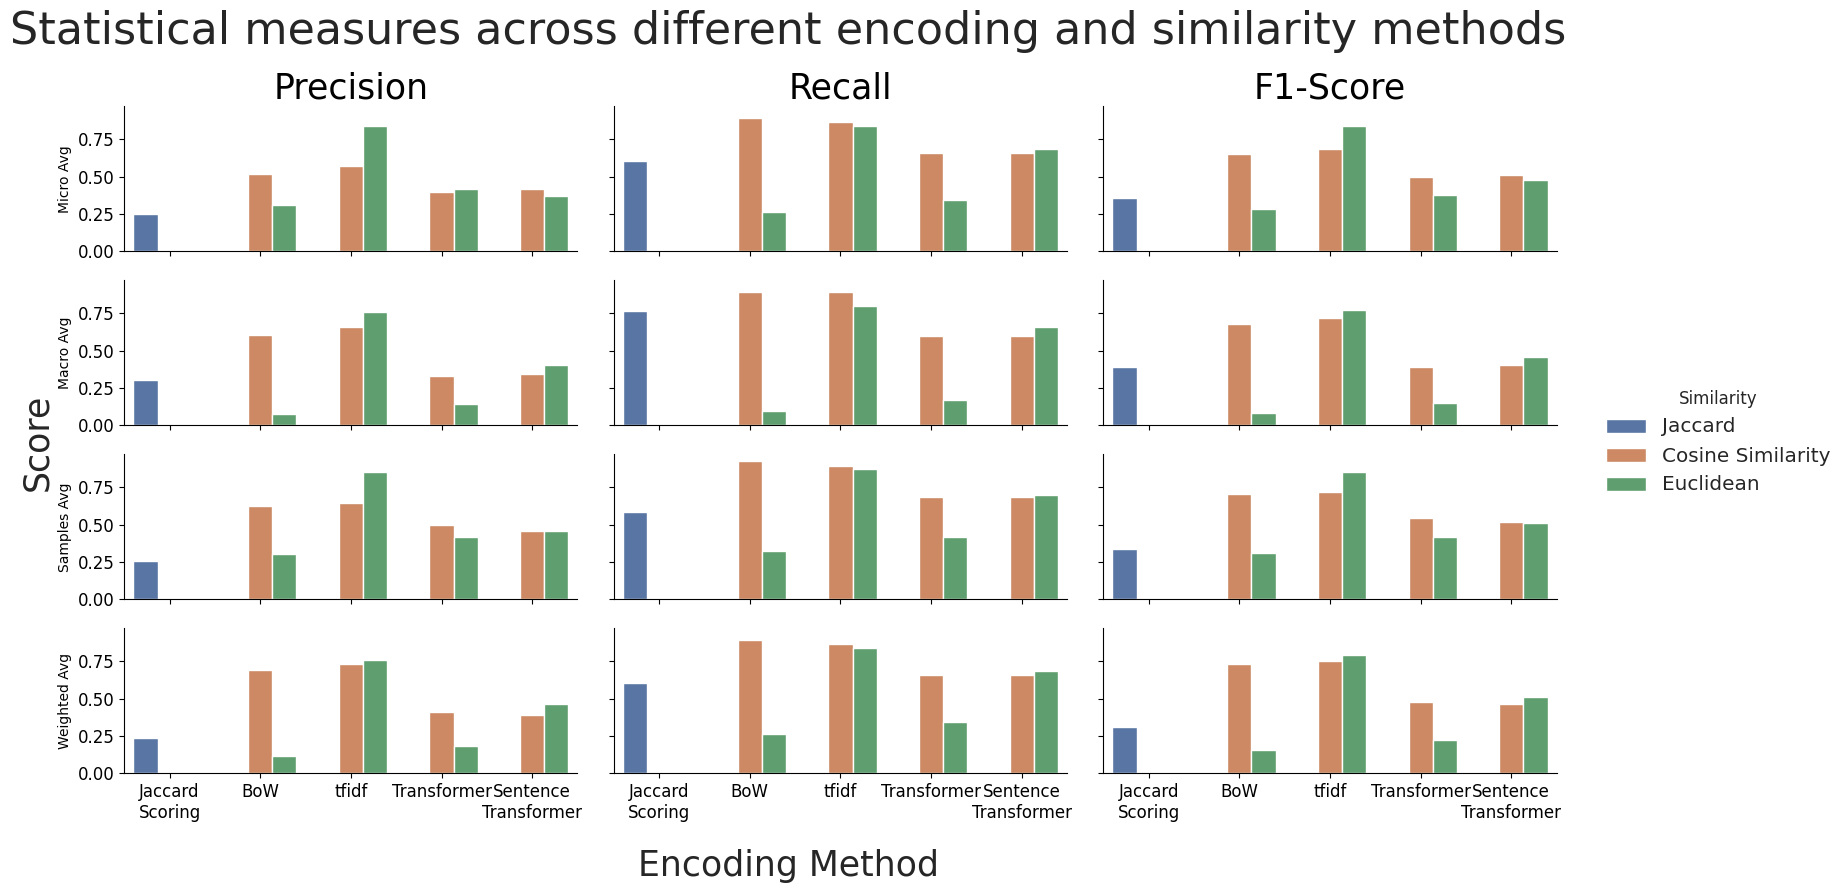

In [51]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(16,9), sharex=True, sharey=True)
axes = axes.T
metric_order = ["precision", "recall", "f1-score"]

sns.set_theme(context="notebook", style="whitegrid")
sns.despine()

legend_not_set = True
labels_plot = ""
plot = ""
for ax_column, metric in zip(axes, metric_order):
    metric_set = False
    for ax, avg in zip(ax_column, avg_methods):
        aux_data = all_scores[(all_scores["AVG"] == avg) & (all_scores["Metric"] == metric)]
        plot = sns.barplot(data=aux_data, x="Encoding", y="Score", hue="Similarity", ax=ax, legend=True)
        ax.legend().remove()
        legend_not_set = False
        ax.set_title(metric.title(), fontsize=25) if not metric_set else 1
        metric_set = True
        ax.set_xlabel("")
        ax.set_ylabel(avg.title()) if metric == "precision" else 1
        ax.tick_params(labelsize=12)

fig.suptitle("Statistical measures across different encoding and similarity methods", fontsize=32)
fig.supxlabel("Encoding Method", fontsize=25)
fig.supylabel("Score", fontsize=25)
plt.tight_layout()
handles, labels_legend = ax.get_legend_handles_labels()
plt.figlegend(handles, labels_legend, loc='center left', bbox_to_anchor=(1, 0.5), title="Similarity", fontsize="large", frameon=False)

plt.show()
